### Predicting Successful Funding of Global Giving Projects

GlobalGiving is an online platform for crowdfunding charitable projects. Non-profit organizations, companies and individuals can use the GlobalGiving site to make requests for donations toward completing specific projects. The status for inactive projects is either “retired” or “funded.” Using this status as a target variable, the goal of this project is to develop a set of features from the project data that is predictive of whether or not a project will be fully funded.



In [65]:
import pandas as pd
import numpy as np
import json

import requests
import time
import itertools

import scipy.stats as stats
import datetime

from xmljson import BadgerFish 
from xml.etree.ElementTree import fromstring
from collections import OrderedDict
bf = BadgerFish(dict_type=OrderedDict)
from json import dumps
from json import loads

import spacy
import re
import string

from nltk.corpus import stopwords
from collections import Counter

from sklearn import cross_validation, metrics
from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
%matplotlib inline


### Data Collection:
GlobalGiving provides an API with access to data for both active and inactive projects. Below, I connect to the API using the  “Get All Projects” method to gather information for all of the projects that have been hosted on their site.



In [162]:
# api token requested from the global giving website
# https://www.globalgiving.org/api/
api_token = 'b6051472-758c-4374-a252-fbb7b351cd19'
api_url_base = 'https://api.globalgiving.org/api/public/projectservice/all/projects'

In [222]:
# list of fields of interest using the "get all projects" method in the api
# https://www.globalgiving.org/api/methods/get-all-projects/

project_fields = ['active','id','title','activities','approvedDate','contactAddress','contactAddress2','contactCity',\
                           'contactCountry','contactName','contactTitle','contactPostal','contactState','country',\
                           'contactUrl','funding','goal','iso3166CountryCode','latitude','longitude','longTermImpact',\
                           'need','numberOfDonations','region','remaining','status','summary','themeName','imageGallerySize',\
                           'number_donation_options','min_donation_amount','max_donation_amount']  

# created a second list to capture data on the organization running the project. organization is a key of the "project" 
# multiple subkeys
organization_fields = ['name','totalProjects','activeProjects','addressLine1','addressLine2','bridgeId','mission',\
                       'city','iso3166CountryCode','url']

# continuous variables: goal, min_donation amount, max_donation_amount,org-totalProjects,activeProjects
# categorical variables: approved date (year), contactCountry, contactCity, region, #_donation_options, themeName, imageGallerySize
#                        status, region, org-city, org-countrycode

In [164]:
# function to parse the data returned from the global giving api. The data is returned all under the key projects. 
# This function returns a list of dictionaries which each list member containing data for an individual project
def parse_projects(data_json, project_fields,organization_fields):
    project_data = []
    # most data is contained within a key '$'. Occasionally, the data is missing the '$' key, the if condition checks
    # for this case and instead returns the value of the parent key
    dollar = '$'
    for i in data_json['projects']['project']:
        dic = {}
        # the list is populated with each project value of interest (from the list above) and then each organization value
        for value in project_fields:
            if value in i.keys():
                if dollar in i[value].keys():
                    dic[value] = i[value]['$']
                else:
                    dic[value] = i[value]
        for value in organization_fields:
            if value in i['organization'].keys():
                if dollar in i['organization'][value].keys():
                    dic['org_'+value] = i['organization'][value]['$']
                else:
                    dic['org_'+value] = i['organization'][value]
        # some projects offer suggested donations amount with a description of what that amount would cover. The amount
        # and number of suggestions varies by project. To capture some of this information this code collects the number
        # of suggestions made, the minimum suggested donation with description, and maximum suggested donation with 
        # description
        if 'donationOptions' in i.keys():
            dic['number_donation_options'] = len(i['donationOptions']['donationOption'])
            if dollar in i['donationOptions']['donationOption'][0]['amount'].keys():
                dic['min_donation_amount'] = i['donationOptions']['donationOption'][0]['amount']['$']
                dic['min_donation_description'] = i['donationOptions']['donationOption'][0]['description']['$']
                if len(i['donationOptions']['donationOption']) > 1:
                    dic['max_donation_amount'] = i['donationOptions']['donationOption'][-1]['amount']['$']
                    dic['max_donation_description'] = i['donationOptions']['donationOption'][-1]['description']['$']
                else:
                    dic['max_donation_amount'] = dic['min_donation_amount']
                    dic['max_donation_description'] = dic['min_donation_description']
            else: 
                dic['min_donation_amount'] = i['donationOptions']['donationOption'][0]['amount']
                dic['min_donation_description'] = i['donationOptions']['donationOption'][0]['description']
                if len(i['donationOptions']['donationOption']) > 1:
                    dic['max_donation_amount'] = i['donationOptions']['donationOption'][-1]['amount']
                    dic['max_donation_description'] = i['donationOptions']['donationOption'][-1]['description']
                else:
                    dic['max_donation_amount'] = dic['min_donation_amount']
                    dic['max_donation_description'] = dic['min_donation_description']
        else:
            dic['number_donation_options'] = 0
        project_data.append(dic)
    return(project_data) 

In [219]:
# use the Python requests library to repeatedly connect to the globalgiving api. 
# the value of the nextProjectId is updated each time  
projectId=1
hasNext = True
n=1

df_ggdata = pd.DataFrame(columns=project_fields)
while hasNext == True:
    search_parameters = {'api_key': 'b6051472-758c-4374-a252-fbb7b351cd19','nextProjectId':projectId}
    r = requests.get('https://api.globalgiving.org/api/public/projectservice/all/projects', params=search_parameters)
    data = r.text
    # convert the xml output to json
    data_string = dumps(bf.data(fromstring(data)))
    data_json = loads(data_string)
    df_temp = pd.DataFrame()
    # parse the output using the function parse_projects
    project_list = parse_projects(data_json,project_fields,organization_fields)
    df_temp = pd.DataFrame(project_list)
    df_ggdata = pd.concat([df_ggdata,df_temp])
    projectId = data_json['projects']['nextProjectId']['$']
    print(projectId)
    #update the value of hasNext from the previous output to drive the condition for the loop
    hasNext = data_json['projects']['hasNext']['$']
    if n % 100 == 0:
        # make occasional backups to disk in case of error
        df_ggdata.to_csv('gg_output'+str(n)+'.csv')
    n+=1
    # add a delay to prevent overloading the api
    time.sleep(5)
    

In [492]:
# check the number of data points and save a final version of the data to csv
print(df_ggdata.shape)
df_ggdata.head(n=100)
print(df_ggdata.columns)
df_ggdata.to_csv('gg_final.csv', encoding='utf-8')
df_ggdata.head()

(19570, 44)
Index(['active', 'activities', 'approvedDate', 'contactAddress',
       'contactAddress2', 'contactCity', 'contactCountry', 'contactName',
       'contactPostal', 'contactState', 'contactTitle', 'contactUrl',
       'country', 'funding', 'goal', 'id', 'imageGallerySize',
       'iso3166CountryCode', 'latitude', 'longTermImpact', 'longitude',
       'max_donation_amount', 'max_donation_description',
       'min_donation_amount', 'min_donation_description', 'need',
       'numberOfDonations', 'number_donation_options', 'org_activeProjects',
       'org_addressLine1', 'org_addressLine2', 'org_bridgeId', 'org_city',
       'org_iso3166CountryCode', 'org_mission', 'org_name',
       'org_totalProjects', 'org_url', 'region', 'remaining', 'status',
       'summary', 'themeName', 'title'],
      dtype='object')


,active,activities,approvedDate,contactAddress,contactAddress2,contactCity,contactCountry,contactName,contactPostal,contactState,...,org_mission,org_name,org_totalProjects,org_url,region,remaining,status,summary,themeName,title
0,False,150 families will be trained in basic business...,2003-05-16T12:57:20-04:00,MicroAid Projects Charity,"Unit 11 DRCA, Business Centre",London,United Kingdom,Toby Beresford,SW11 5HD,United Kingdom,...,NaN,NaN,0.0,NaN,Asia and Oceania,0.00,funded,Helping 150 poor Indonesian women in 14 villag...,Economic Development,Poor women micro-enterprise development-Indonesia
1,False,Self-sustainability is fundamental to DDD’s mi...,2003-05-19T13:36:28-04:00,"#119, st. 360",NaN,Phnom Penh,Cambodia,NaN,Prey I,Toul Svey,...,DDD has a duel mission\r\n-To establish a sust...,Digital Divide Data,1.0,http://www.digitaldividedata.com,Asia and Oceania,220000.00,retired,DigitalDivideData is an IT socially conscious ...,Economic Development,Digital Divide Data (DDD)
2,False,The goal of the project is to supply at least ...,2003-05-19T17:00:31-04:00,"HC 72, Box 11506",NaN,Fishlake Valley,United States,NaN,89010,Nevada,...,Our goal is to supply computer technology and ...,Global Stewardship Foundation Africa,1.0,http://www.Gsfa.us,Africa,4109.47,funded,Reusing low-end computers from the developed w...,Economic Development,Bridging the digital divide with computers
3,False,Volunteer engineers will host workshops that p...,2003-05-19T18:43:24-04:00,3 Clark Road,NaN,Millis,United States,NaN,02054-1213,Massachusetts,...,Global Village Engineers is a corps of volunte...,Global Village Engineers,3.0,http://www.gvengineers.org,South/Central America and the Caribbean,33000.00,retired,Enhancing community knowledge to better evalua...,Economic Development,Community-based landslide awareness in El Salv...
4,False,Experienced engineers will conduct workshops t...,2003-05-20T09:10:50-04:00,3 Clark Road,NaN,Millis,United States,NaN,02054-1213,Massachusetts,...,Global Village Engineers is a corps of volunte...,Global Village Engineers,3.0,http://www.gvengineers.org,South/Central America and the Caribbean,33000.00,retired,Empowering communities through participation i...,Economic Development,Community-based flood protection in El Salvador


### Data Exploration:
The output from the Get All Projects methods includes multiple text fields (ie. project name, project summary), continuous data fields (ie. goal amount, suggested donation amounts) and categorical data (project countries, themes). Below, I explore some of this data to look for patterns that may be useful in feature generation.

In [197]:
# load the data as a features dataset, drop some of the less useful columns or ones that are related 
# to the outcome like funding and numberofdonations
df_features = pd.read_csv('gg_final.csv')
df_features = df_features.drop(['contactAddress','contactAddress2','contactName','contactTitle','funding','remaining',\
                                'org_addressLine1','org_city','org_bridgeId','contactPostal','contactState','numberOfDonations','org_addressLine2','active','contactUrl','org_url'],axis=1)
df_features.reset_index(drop=True)
df_features = df_features[df_features.status != 'unsearchable']
df_features = df_features[df_features.status != 'active']

#convert the date into year to look at differences in project number and funding over time
df_features['approvedDate'] = pd.to_datetime(df_features['approvedDate'])
df_features['year'] = pd.DatetimeIndex(df_features['approvedDate']).year

    
# manage null values

# replace null values in imageGallery size with 0
df_features['imageGallerySize'].fillna(0, inplace=True)
# replace max/min donation amount with -1 and corresponding descriptions to empty strings 
df_features['max_donation_amount'].fillna(-1, inplace=True)
df_features['min_donation_amount'].fillna(-1, inplace=True)
df_features['min_donation_description'].fillna('', inplace=True)
df_features['max_donation_description'].fillna('', inplace=True)

#replace missing org name values with 'not an organization' (individual running project)
df_features['org_name'].fillna('', inplace=True)
#replace missing text values with empty string
df_features['org_mission'].fillna('', inplace=True)
df_features['org_activeProjects'].fillna(-1, inplace=True)
                 
# how many null values
# print(df_features['year'])
#print(df_features.isnull().sum())

# target value
df_features['status_binary'] = np.where(df_features['status']=='retired',0,1)
Y = df_features['status_binary']
print(Y[0:5],df_features['status'][0:5])


0    1
1    0
2    1
3    0
4    0
Name: status_binary, dtype: int32 0     funded
1    retired
2     funded
3    retired
4    retired
Name: status, dtype: object


In [35]:
# number of funded versus retired
df_status = df_features.groupby('status').count().reset_index()
df_status.head()

,status,Unnamed: 0,activities,approvedDate,contactCity,contactCountry,country,goal,id,imageGallerySize,...,org_activeProjects,org_iso3166CountryCode,org_mission,org_name,org_totalProjects,region,summary,themeName,title,year
0,funded,5763,5763,5763,5762,5763,5763,5763,5763,5763,...,5763,5693,5763,5763,5763,5763,5763,5763,5763,5763
1,retired,10267,10267,10267,10266,10267,10267,10267,10267,10267,...,10267,10148,10267,10267,10267,10267,10267,10267,10267,10267


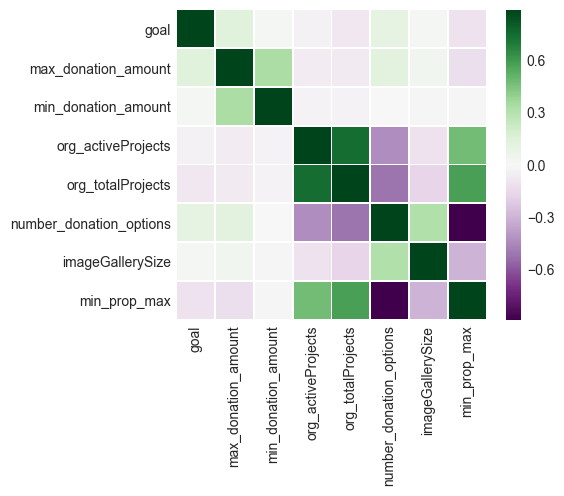

,goal,max_donation_amount,min_donation_amount,org_activeProjects,org_totalProjects,number_donation_options,imageGallerySize,status,min_prop_max
0,3046.0,-1.0,-1.0,-1.0,0.0,0.0,11.0,funded,1.0
1,220000.0,-1.0,-1.0,0.0,1.0,0.0,1.0,retired,1.0
2,5500.0,-1.0,-1.0,0.0,1.0,0.0,1.0,funded,1.0
3,33000.0,-1.0,-1.0,0.0,3.0,0.0,1.0,retired,1.0
4,33000.0,-1.0,-1.0,0.0,3.0,0.0,1.0,retired,1.0


In [203]:
# continuous variables: goal, min_donation amount, max_donation_amount,org-totalProjects,activeProjects, #_donation_options, imageGallerySize (status output to compare)
df_cont_features = df_features.filter(['goal','max_donation_amount','min_donation_amount','org_activeProjects','org_totalProjects','number_donation_options',\
                                       'imageGallerySize','status'], axis = 1)

df_cont_features['min_prop_max'] = df_cont_features['min_donation_amount'] / df_cont_features['max_donation_amount']
df_cont_features['min_prop_max'].fillna(0, inplace=True)


corrmat = df_cont_features.corr()
#print(corrmat)

sns.set_style("white")
f, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(corrmat, vmax=.8, square=True,cmap="PRGn",linewidths=.5)
plt.savefig('heatmap.png')
plt.show()

# Outcome: Not a lot of correlation in the continuous variables. The negative correlation between the number
# of donation options and the total projects is likely related to "microprojects" that are subprojects
# of larger projects. Microprojects are not allowed to have suggested donation options
# I'll drop org active projects from the feature set due to correlation with total projects

df_cont_features.head()


                       goal  imageGallerySize  max_donation_amount  \
status                                                               
funded  count  5.763000e+03       5763.000000          5763.000000   
        mean   3.019402e+04          4.948464          1892.018914   
        std    1.621377e+05          4.244802         12027.556366   
        min    5.000000e+01          0.000000            -1.000000   
        25%    1.800000e+03          1.000000            -1.000000   
        50%    9.080000e+03          4.000000           200.000000   
        75%    2.500000e+04          7.000000          1000.000000   
        max    1.000000e+07         76.000000        620369.000000   
retired count  1.026700e+04      10267.000000         10267.000000   
        mean   3.605941e+04          4.990065          3379.662121   
        std    8.717614e+04          4.319693         19209.122707   
        min    2.500000e+02          0.000000            -1.000000   
        25%    5.000

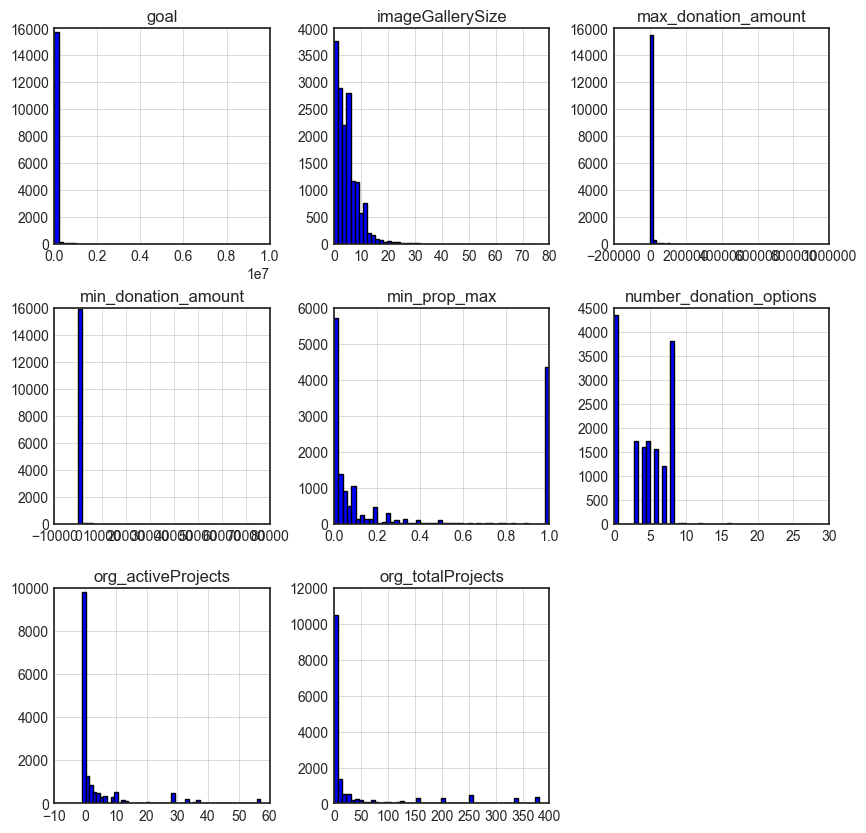

In [292]:
# Descriptive statistics by group.
print(df_cont_features.groupby('status').describe())
df_cont_features.head()
# Test whether group differences are significant.
for col in df_cont_features.loc[:,'goal':'imageGallerySize'].columns:
    print(col)
    print(stats.ttest_ind(
        df_cont_features[df_cont_features['status'] == 'retired'][col].dropna(),
        df_cont_features[df_cont_features['status'] == 'funded'][col].dropna()))

%matplotlib inline

x = df_cont_features.hist(figsize=(10,10),bins=50)


In [38]:
print(stats.ttest_ind(
        df_cont_features[df_cont_features['status'] == 'retired']['min_prop_max'].dropna(),
        df_cont_features[df_cont_features['status'] == 'funded']['min_prop_max'].dropna()))

Ttest_indResult(statistic=-11.097769520437867, pvalue=1.6336937229136669e-28)


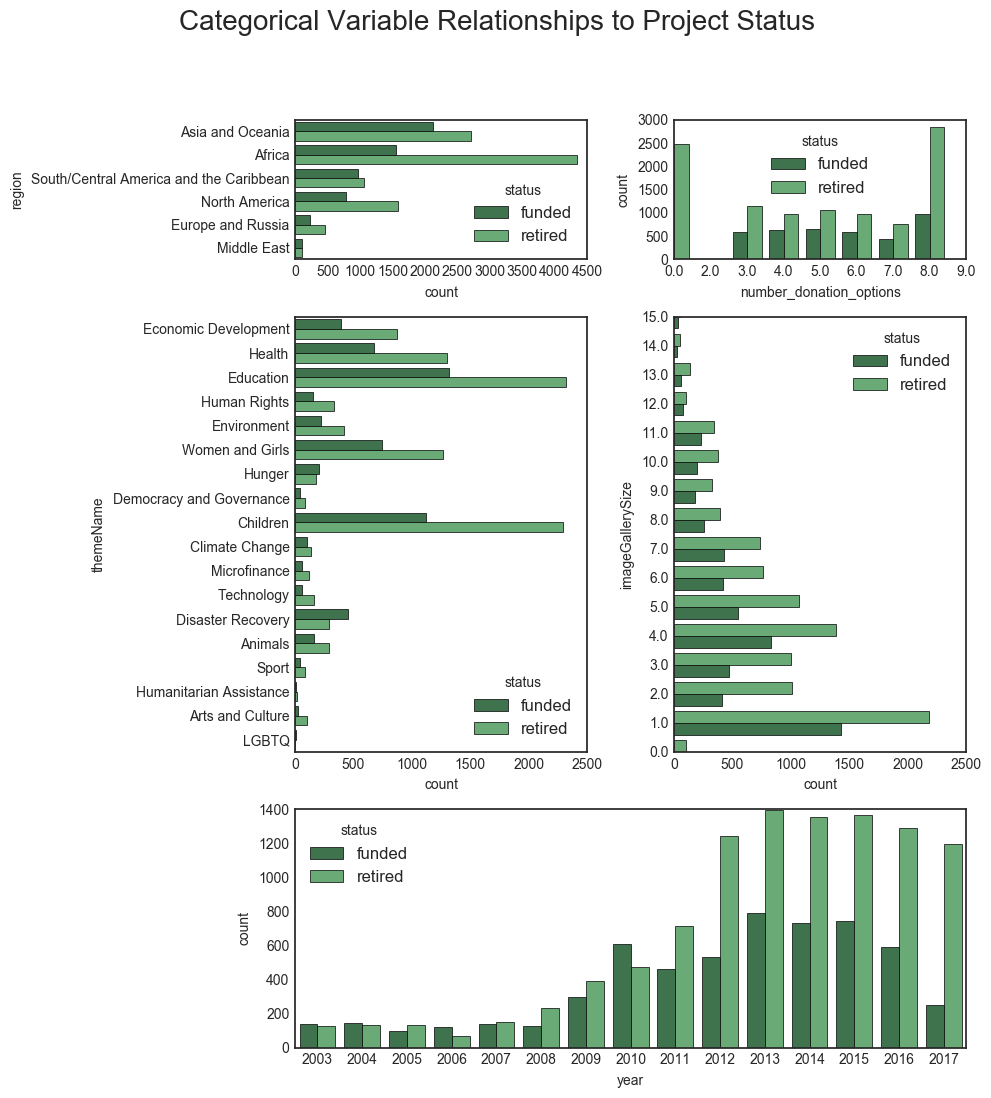

In [39]:
# categorical variables: year, contactCountry, contactCity, #_donation_options, themeName, imageGallerySize
#                        status, region, org-city, org-countrycode
df_cat_features = df_features.filter(['year','region','contactCountry','contactCity','number_donation_options','themeName',\
                                       'imageGallerySize','org_iso3166CountryCode','status','org_name'], axis = 1)


# Plot counts for each combination of levels.
fig, ax = plt.subplots(figsize=(10,10), ncols=10, nrows=10)
plt.suptitle("Categorical Variable Relationships to Project Status", y = 1.09, fontsize=20)
# ax1=plt.subplot(611)
# sns.countplot(y="region", hue="status", data=df_cat_features, palette="Greens_d")
# ax2=plt.subplot(612)
# sns.countplot(y="year", hue="status", data=df_cat_features, palette="Greens_d")

ax1 = plt.subplot2grid((10, 10), (0, 0), colspan=5,rowspan=2)
sns.countplot(y="region", hue="status", data=df_cat_features, palette="Greens_d",edgecolor=(0,0,0),linewidth=.5)
ax2 = plt.subplot2grid((10, 10), (2, 0), colspan=5, rowspan=5)
sns.countplot(y="themeName", hue="status", data=df_cat_features, palette="Greens_d",edgecolor=(0,0,0),linewidth=.5)
ax3 = plt.subplot2grid((10, 10), (2, 5), colspan=5,rowspan=5)
sns.countplot(y="imageGallerySize", hue="status", data=df_cat_features, palette="Greens_d",edgecolor=(0,0,0),linewidth=.5)
ax3.set_ylim(0,15)
ax4 = plt.subplot2grid((10, 10), (0, 5), colspan=5, rowspan=2)
sns.countplot(x="number_donation_options", hue="status", data=df_cat_features, palette="Greens_d",edgecolor=(0,0,0),linewidth=.5)
ax4.set_xlim(0,8)
ax5 = plt.subplot2grid((10, 10), (7, 0), colspan=10, rowspan = 3)
sns.countplot(x="year", hue="status", data=df_cat_features, palette="Greens_d",edgecolor=(0,0,0),linewidth=.5)
plt.tight_layout()
plt.savefig('categorical.png')

In [40]:
# chi-square - are there significant differences in funding/retired projects based on categories?
counttable = pd.crosstab(df_cat_features['region'], df_cat_features['status'])

print("Is funding of projects different by Region")
print(stats.chisquare(counttable, axis=None))

counttable['proportion_funded'] = counttable['funded']/(counttable['funded']+counttable['retired'])
print(counttable)
df_cat_NA_Eur = df_cat_features.loc[((df_cat_features['region'] == 'Europe and Russia') | (df_cat_features['region'] == 'North America')),  ['region','status']]
df_cat_Afr_Eur = df_cat_features.loc[((df_cat_features['region'] == 'Europe and Russia') | (df_cat_features['region'] == 'Africa')),  ['region','status']]

counttable_NA_Eur = pd.crosstab(df_cat_NA_Eur['region'], df_cat_NA_Eur['status'])
counttable_Afr_Eur = pd.crosstab(df_cat_Afr_Eur['region'], df_cat_Afr_Eur['status'])
print(counttable_NA_Eur)
print(stats.chisquare(counttable_NA_Eur, axis=None))
print(counttable_Afr_Eur)
print(stats.chisquare(counttable_Afr_Eur, axis=None))
print("")
print("Is funding of projects different by Theme")
counttable_theme = pd.crosstab(df_cat_features['themeName'], df_cat_features['status'])
print(stats.chisquare(counttable_theme, axis=None))

counttable_theme['proportion_funded'] = counttable_theme['funded']/(counttable_theme['funded']+counttable_theme['retired'])
print(counttable_theme)
df_cat_health_Env = df_cat_features.loc[((df_cat_features['themeName'] == 'Health') | (df_cat_features['themeName'] == 'Environment')),  ['themeName','status']]
df_cat_Afr_Eur = df_cat_features.loc[((df_cat_features['region'] == 'Europe and Russia') | (df_cat_features['region'] == 'Africa')),  ['region','status']]

counttable_health_Env = pd.crosstab(df_cat_health_Env['themeName'], df_cat_NA_Eur['status'])
# counttable_Afr_Eur = pd.crosstab(df_cat_Afr_Eur['region'], df_cat_Afr_Eur['status'])
print(counttable_health_Env)
print(stats.chisquare(counttable_health_Env, axis=None))
# print(counttable_Afr_Eur)
# print(stats.chisquare(counttable_Afr_Eur, axis=None))



Is funding of projects different by Region
Power_divergenceResult(statistic=12855.444791016844, pvalue=0.0)
status                                   funded  retired  proportion_funded
region                                                                     
Africa                                     1548     4337           0.263042
Asia and Oceania                           2127     2713           0.439463
Europe and Russia                           223      459           0.326979
Middle East                                 107      110           0.493088
North America                               787     1592           0.330811
South/Central America and the Caribbean     971     1056           0.479033
status             funded  retired
region                            
Europe and Russia     223      459
North America         787     1592
Power_divergenceResult(statistic=1400.6047043449853, pvalue=2.1775111348419434e-303)
status             funded  retired
region                  

### Spatial patterns in funding 


In [18]:
# create a new dataframe for mapping funding by country

df_maps_loc = df_features.filter(['iso3166CountryCode','country','status'],axis=1)
df_maps_loc = df_maps_loc.dropna()

df_maps_goal = df_features.filter(['iso3166CountryCode','goal'],axis=1)
df_maps_goal = df_maps_goal.groupby(['iso3166CountryCode']).mean()
df_maps_goal = df_maps_goal.reset_index()

print(df_maps_goal.head())
df1 = df_maps_loc.groupby(['iso3166CountryCode','country'],as_index=False).count()
df1 = df1.rename(columns={'total_project':'country','status':'total_count'})

df2 = df_maps_loc.groupby(['iso3166CountryCode', 'status']).count().reset_index()
df2 = df2.rename(columns ={'country':'count'})
# create list of countries that have retired, but not funded
country_retired = ['AE', 'AT', 'AZ', 'BM', 'BQ', 'CG', 'DK', 'DZ', 'FI', 'GA', 'GD', 'GW', 'HR', 'IR', 'KP',\
                   'KY', 'LC', 'MR', 'MU', 'NO', 'PW', 'SG', 'SR', 'TM', 'TN', 'VC']
# create a list of countries that have funded, but no retired
country_funded = ['BB', 'CF', 'MV', 'OM', 'PN']

for country in country_retired:
    new_row = [{'iso3166CountryCode': country, 'status': 'funded', 'count':0}]
    df_temp = pd.DataFrame(new_row)
    df2 = pd.concat([df2, df_temp]) 
    
for country in country_funded:
    new_row = [{'iso3166CountryCode': country, 'status': 'funded', 'count':0}]
    df_temp = pd.DataFrame(new_row)
    df2 = pd.concat([df2, df_temp])
    
df2 = df2.sort_values(by=['iso3166CountryCode'])

df3 = df2.pivot_table(index='iso3166CountryCode', columns='status')['count']
df3 = df3.rename(columns ={'status':'iso3166CountryCode'})
df3 = df3.reset_index()

df1['funded'] = df3['funded'].astype('int')
df1['retired'] = df1['total_count'] - df1['funded']
df1['percent_funded'] = (df1['funded'] / df1['total_count']) * 100
df1['avg_goal'] = df_maps_goal['goal']
#df1['retired'] = df3['retired'].astype('int')
# df1 = df1.reset_index(drop=True)
df1 = df1.set_index(df1['iso3166CountryCode'])
df1 = df1.drop(['iso3166CountryCode'],axis=1)
df1.head()

  iso3166CountryCode          goal
0                 AE  28333.333333
1                 AF  17075.596447
2                 AL  41911.000000
3                 AM  18646.320000
4                 AO  36651.125000


,country,total_count,funded,retired,percent_funded,avg_goal
iso3166CountryCode,,,,,,
AE,United Arab Emirates,3,0,3,0.000000,28333.333333
AF,Afghanistan,394,329,65,83.502538,17075.596447
AL,Albania,9,3,6,33.333333,41911.000000
AM,Armenia,25,13,12,52.000000,18646.320000
AO,Angola,8,5,3,62.500000,36651.125000


In [24]:
# create maps using http://ramiro.org/notebook/basemap-choropleth/ as a guide:

# get map of world w/ country boundaries from natural earth data http://www.naturalearthdata.com/downloads/10m-cultural-vectors/
from geonamescache import GeonamesCache
from slugify import slugify
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
#import shapefile

shapefile = 'ne_10m_admin_0_countries/ne_10m_admin_0_countries'


import geopandas as gp

shape_file = gp.read_file('worldmap\worldmap.shp')
print(shape_file.columns)
# print(shape_file['ISO_A2'])

# cols = ['Country Name', 'Country Code', year]
title = 'Number of Projects per Country'
imgfile = '{}.png'.format(slugify(title))


Index(['scalerank', 'featurecla', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT',
       'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG',
       'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN',
       'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT',
       'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13',
       'POP_EST', 'POP_RANK', 'GDP_MD_EST', 'POP_YEAR', 'LASTCENSUS',
       'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'WIKIPEDIA', 'FIPS_10_', 'ISO_A2',
       'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID',
       'WOE_ID_EH', 'WOE_NOTE', 'ADM0_A3_IS', 'ADM0_A3_US', 'ADM0_A3_UN',
       'ADM0_A3_WB', 'CONTINENT', 'REGION_UN', 'SUBREGION', 'REGION_WB',
       'NAME_LEN', 'LONG_LEN', 'ABBREV_LEN', 'TINY', 'HOMEPART', 'MIN_ZOOM',
       'MIN_LABEL', 'MAX_LABEL', 'geometry'],
      dtype='object')


In [26]:
num_colors = 10
values = df1['total_count']

cm = plt.get_cmap('Greens')
scheme = [cm(i / num_colors) for i in range(num_colors)]
bins = np.linspace(values.min(), values.max(), num_colors)
# digitize returns the indices of the bins to which each value belongs
df1['bin'] = np.digitize(values, bins) - 1
df1.sort_values('bin', ascending=False).head(10)



,country,total_count,funded,retired,percent_funded,avg_goal,bin
iso3166CountryCode,,,,,,,
IN,India,2339,877,1462,37.494656,29010.526721,9
US,United States,2132,690,1442,32.363977,32361.606004,8
UG,Uganda,1105,245,860,22.171946,31605.419910,4
KE,Kenya,1013,267,746,26.357354,38447.982231,3
HT,Haiti,546,366,180,67.032967,24865.749084,2
AF,Afghanistan,394,329,65,83.502538,17075.596447,1
ZA,South Africa,384,118,266,30.729167,36366.078125,1
NG,Nigeria,430,74,356,17.209302,35078.183721,1
NP,Nepal,362,181,181,50.000000,29327.469613,1


C:\Users\stace\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


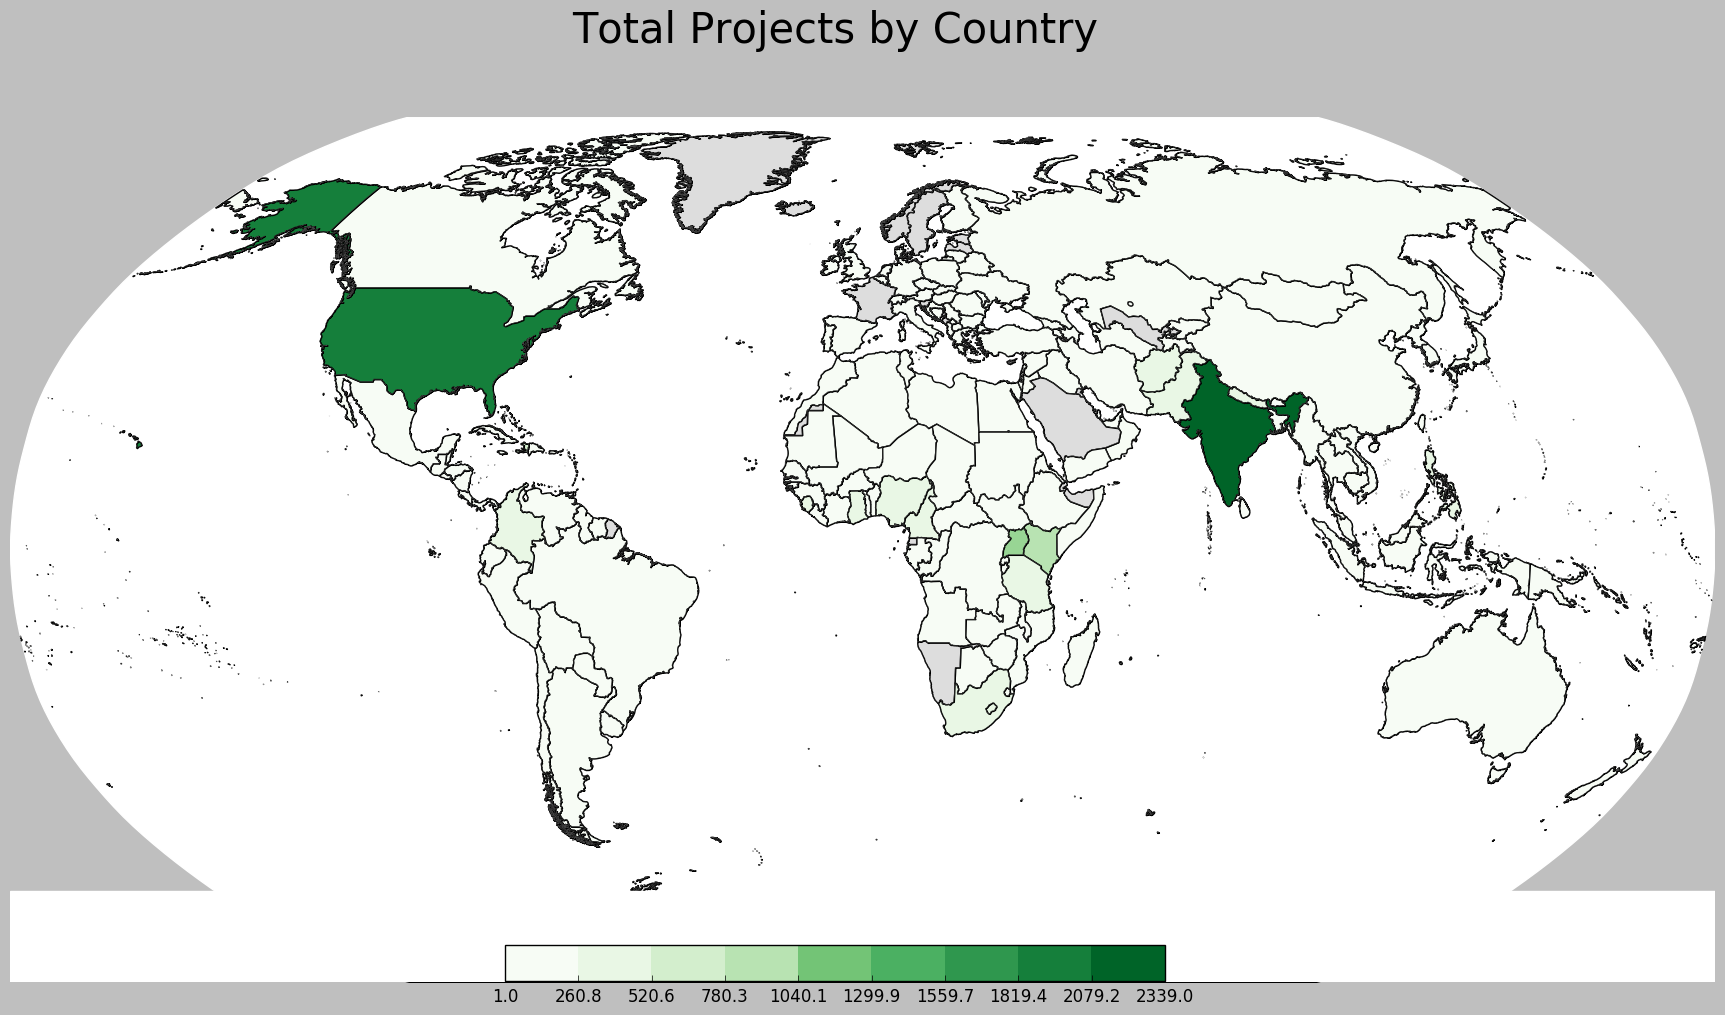

In [27]:
mpl.style.use('classic')
fig = plt.figure(figsize=(22, 12))

ax = fig.add_subplot(111, axisbg='w', frame_on=False)
fig.suptitle('Total Projects by Country', fontsize=30, y=.95)

m = Basemap(lon_0=0, projection='robin')
m.drawmapboundary(color='white')



m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)
for info, shape in zip(m.units_info, m.units):
    iso2 = info['ISO_A2']
    if iso2 not in df1.index:
         color = '#dddddd'     
    else:
         color = scheme[df1.ix[iso2]['bin']]

    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)

#Cover up Antarctica so legend can be placed over it.
ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

# Draw color legend.
ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])
description = "Most projects raising money through GlobalGiving are to benefit causes in India and the United States"
# # Set the map footer.
# plt.annotate(descripton, xy=(-.8, -3.2), size=14, xycoords='axes fraction')

plt.savefig(imgfile, bbox_inches='tight', pad_inches=.2)

In [28]:
num_colors = 10
values = df1['percent_funded']

cm = plt.get_cmap('Greens')
scheme = [cm(i / num_colors) for i in range(num_colors)]
bins = np.linspace(values.min(), values.max(), num_colors)
# digitize returns the indices of the bins to which each value belongs
df1['bin'] = np.digitize(values, bins) - 1
df1.sort_values('bin', ascending=False).head(10)

,country,total_count,funded,retired,percent_funded,avg_goal,bin
iso3166CountryCode,,,,,,,
VE,Venezuela,9,8,1,88.888889,45352.555556,9
AF,Afghanistan,394,329,65,83.502538,17075.596447,8
IQ,Iraq,21,17,4,80.952381,11574.761905,8
XK,Kosovo,5,4,1,80.000000,33548.400000,8
GY,Guyana,6,5,1,83.333333,10166.666667,8
TW,Taiwan,10,7,3,70.000000,43701.700000,7
KZ,Kazakhstan,4,3,1,75.000000,23198.750000,7
VU,Vanuatu,4,3,1,75.000000,43500.000000,7
JP,Japan,54,35,19,64.814815,299533.685185,6


C:\Users\stace\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


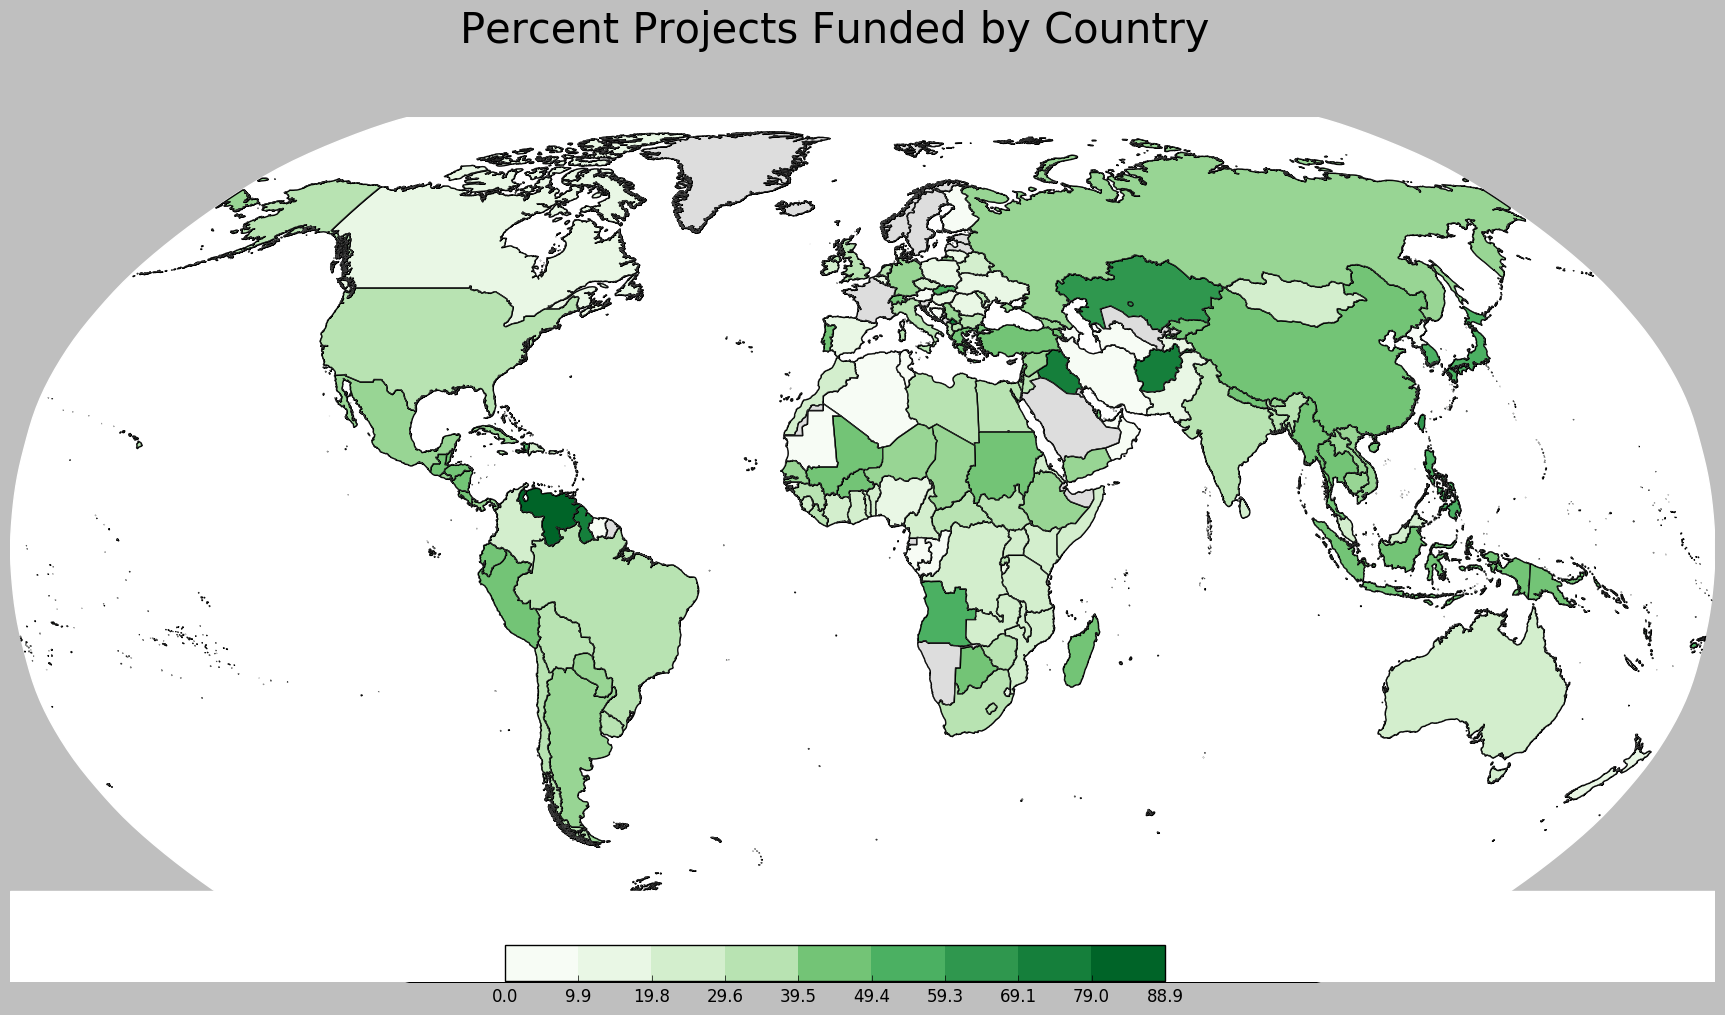

In [30]:
fig = plt.figure(figsize=(22, 12))

ax = fig.add_subplot(111, axisbg='w', frame_on=False)
fig.suptitle('Percent Projects Funded by Country', fontsize=30, y=.95)

m = Basemap(lon_0=0, projection='robin')
m.drawmapboundary(color='white')



m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)
for info, shape in zip(m.units_info, m.units):
    iso2 = info['ISO_A2']
    if iso2 not in df1.index:
         color = '#dddddd'     
    else:
         color = scheme[df1.ix[iso2]['bin']]

    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)

#Cover up Antarctica so legend can be placed over it.
ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

# Draw color legend.
ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

# Set the map footer.
#plt.annotate(descripton, xy=(-.8, -3.2), size=14, xycoords='axes fraction')

plt.savefig(imgfile, bbox_inches='tight', pad_inches=.2)

In [481]:
num_colors = 10
values = df1['avg_goal']

cm = plt.get_cmap('Greens')
scheme = [cm(i / num_colors) for i in range(num_colors)]
bins = np.linspace(values.min(), values.max(), num_colors)
# digitize returns the indices of the bins to which each value belongs
df1['bin'] = np.digitize(values, bins) - 1
df1.sort_values('bin', ascending=False).head(10)

,country,total_count,funded,retired,percent_funded,avg_goal,bin
iso3166CountryCode,,,,,,,
JP,Japan,54,35,19,64.814815,299533.685185,9
PT,Portugal,2,1,1,50.000000,268500.000000,8
IT,Italy,11,4,7,36.363636,217354.545455,6
CH,Switzerland,4,2,2,50.000000,141249.750000,4
TD,Chad,9,4,5,44.444444,111491.666667,3
SR,Suriname,2,0,2,0.000000,103500.000000,3
HR,Croatia,1,0,1,0.000000,89671.000000,2
KY,Cayman Islands,1,0,1,0.000000,90000.000000,2
AU,Australia,18,5,13,27.777778,87451.055556,2


C:\Users\stace\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


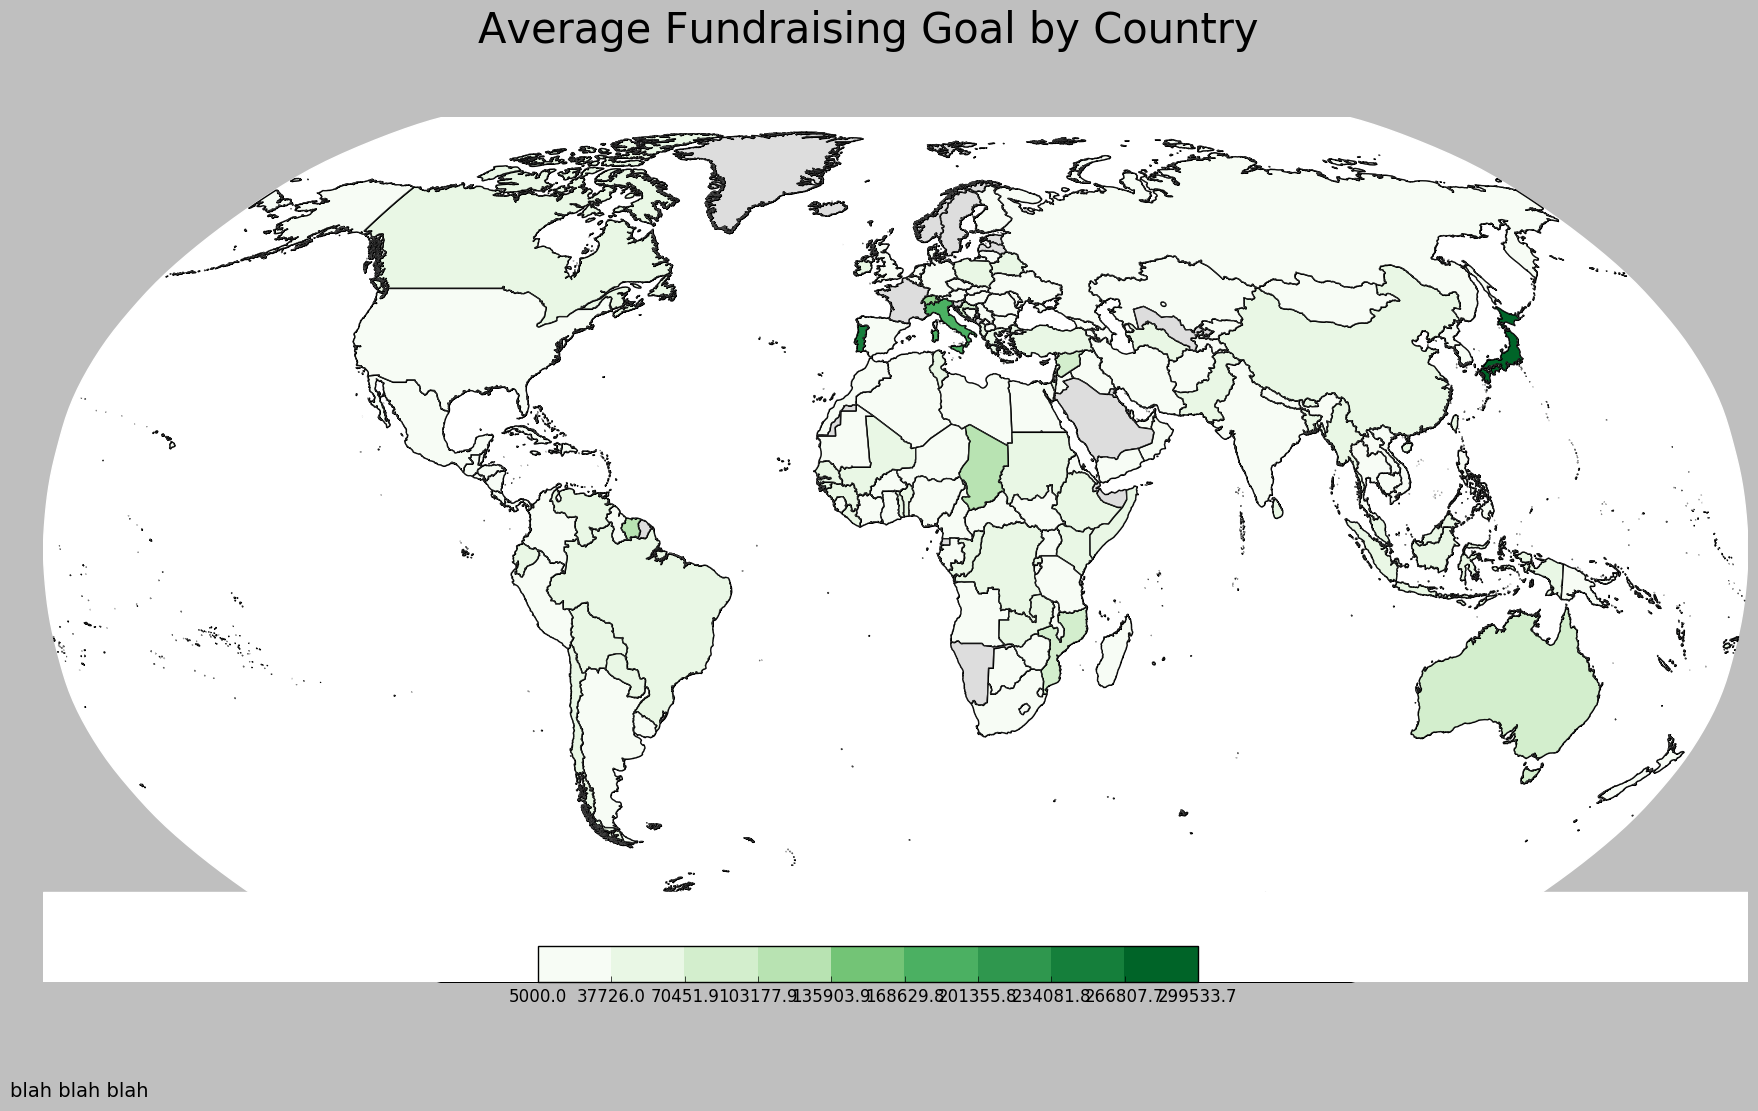

In [483]:
fig = plt.figure(figsize=(22, 12))

ax = fig.add_subplot(111, axisbg='w', frame_on=False)
fig.suptitle('Average Fundraising Goal by Country', fontsize=30, y=.95)

m = Basemap(lon_0=0, projection='robin')
m.drawmapboundary(color='white')



m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)
for info, shape in zip(m.units_info, m.units):
    iso2 = info['ISO_A2']
    if iso2 not in df1.index:
         color = '#dddddd'     
    else:
         color = scheme[df1.ix[iso2]['bin']]

    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)

#Cover up Antarctica so legend can be placed over it.
ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

# Draw color legend.
ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

# Set the map footer.
plt.annotate(descripton, xy=(-.8, -3.2), size=14, xycoords='axes fraction')

# plt.savefig(imgfile, bbox_inches='tight', pad_inches=.2)

### Create a Features Dataframe
Combining features from both the continous and categorical data as predictors for modeling

In [41]:
# create a new features dataframe to populate with features generated from continuous, categorical
# text fields
final_continuous = ['goal','min_donation_amount','max_donation_amount','min_prop_max']
features_final = pd.DataFrame()
for feature in final_continuous:
    features_final = pd.concat([features_final,df_cont_features[feature]],axis=1)
    
features_final.head()

,goal,min_donation_amount,max_donation_amount,min_prop_max
0,3046.0,-1.0,-1.0,1.0
1,220000.0,-1.0,-1.0,1.0
2,5500.0,-1.0,-1.0,1.0
3,33000.0,-1.0,-1.0,1.0
4,33000.0,-1.0,-1.0,1.0


In [42]:
# create dummies from categorical values to add to feature set
categories_list = ['region','themeName','contactCountry','org_iso3166CountryCode','year']
features_dummies = pd.DataFrame()
for feature in categories_list:
    features_dummies = pd.concat([features_dummies,pd.get_dummies(df_cat_features[feature])],axis=1)

print(features_dummies.shape)
features_final = pd.concat([features_final,features_dummies],axis=1)
features_list = list(features_final.columns)

print(features_final.shape)


(16030, 339)
(16030, 343)


### Create Features from Text Fields
The majority of information on the GlobalGiving site is text based. The output from the api includes the title, activities, long term impact, summary, need and other information for each project. In order to engineer predictive features from this data, I combined the text for each project into a single field and performed tf-idf analysis to identify words that differentiated projects from each other.

In [43]:
# text variables: 'activities', longTermImpact', 'max_donation_description', 'min_donation_description', 'need','org_mission', 'org_name',
#       'summary', 'title'

df_text_features = df_features.filter(['title','activities','longTermImpact','summary','need','org_name','org_mission','min_donation_description',\
                                       'max_donation_description','status'], axis = 1)


df_text_features.head()

,title,activities,longTermImpact,summary,need,org_name,org_mission,min_donation_description,max_donation_description,status
0,Poor women micro-enterprise development-Indonesia,150 families will be trained in basic business...,150 poor families will take the first step out...,Helping 150 poor Indonesian women in 14 villag...,35 million people in Indonesia live below the ...,,,,,funded
1,Digital Divide Data (DDD),Self-sustainability is fundamental to DDD’s mi...,The outcomes of this project include employeei...,DigitalDivideData is an IT socially conscious ...,As the world’s economy becomes increasingly in...,Digital Divide Data,DDD has a duel mission\r\r\n-To establish a su...,,,retired
2,Bridging the digital divide with computers,The goal of the project is to supply at least ...,We have sent our first 94 PCs and 6 printers i...,Reusing low-end computers from the developed w...,Currently U.S. businesses pay for the disposal...,Global Stewardship Foundation Africa,Our goal is to supply computer technology and ...,,,funded
3,Community-based landslide awareness in El Salv...,Volunteer engineers will host workshops that p...,Community participation will result in a proje...,Enhancing community knowledge to better evalua...,"In 2001, earthquakes in El Salvador triggered ...",Global Village Engineers,Global Village Engineers is a corps of volunte...,,,retired
4,Community-based flood protection in El Salvador,Experienced engineers will conduct workshops t...,"The project will empower the community's men, ...",Empowering communities through participation i...,After Hurricane Mitch caused devastating flood...,Global Village Engineers,Global Village Engineers is a corps of volunte...,,,retired


In [44]:
# Utility function for text cleaning.
def text_cleaner(text):    
    # remove parentheses
    text = re.sub("[\(|\)]", "", text)
    # remove non-ascii characters
    text = re.sub(r'[^\x00-\x7F]','', text)
    # remove single character words
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    # remove hyphen
    text = re.sub(r'-',' ',text)
    text = ' '.join(text.split())
    return text

In [45]:
text_list = ['title','activities','longTermImpact','summary','need','org_mission','min_donation_description',\
                                       'max_donation_description']

# clean up the text (run for each column)
for index, row in df_text_features.iterrows():
    for col in text_list:
        i = str(row[col]).lower()
        i = text_cleaner(i)
        df_text_features.loc[index, col] = i

In [46]:
# create a combined text field to run tf-idf
df_text_features['combined_text'] = df_text_features[['title', 'activities','longTermImpact','summary','max_donation_description',\
                                                      'min_donation_description','need','org_mission']].apply\
                                                      (lambda x: ' '.join(x), axis=1)


In [47]:
df_text_features.to_csv('gg_text_features.csv',encoding='utf-8')
df_text_features.head()

,title,activities,longTermImpact,summary,need,org_name,org_mission,min_donation_description,max_donation_description,status,combined_text
0,poor women micro enterprise development indonesia,150 families will be trained in basic business...,150 poor families will take the first step out...,helping 150 poor indonesian women in 14 villag...,35 million people in indonesia live below the ...,,,,,funded,poor women micro enterprise development indone...
1,digital divide data ddd,self sustainability is fundamental to ddds mis...,the outcomes of this project include employeei...,digitaldividedata is an it socially conscious ...,as the worlds economy becomes increasingly int...,Digital Divide Data,ddd has duel mission to establish sustainable ...,,,retired,digital divide data ddd self sustainability is...
2,bridging the digital divide with computers,the goal of the project is to supply at least ...,we have sent our first 94 pcs and 6 printers i...,reusing low end computers from the developed w...,currently .. businesses pay for the disposal o...,Global Stewardship Foundation Africa,our goal is to supply computer technology and ...,,,funded,bridging the digital divide with computers the...
3,community based landslide awareness in el salv...,volunteer engineers will host workshops that p...,community participation will result in project...,enhancing community knowledge to better evalua...,"in 2001, earthquakes in el salvador triggered ...",Global Village Engineers,global village engineers is corps of volunteer...,,,retired,community based landslide awareness in el salv...
4,community based flood protection in el salvador,experienced engineers will conduct workshops t...,"the project will empower the community' men, w...",empowering communities through participation i...,after hurricane mitch caused devastating flood...,Global Village Engineers,global village engineers is corps of volunteer...,,,retired,community based flood protection in el salvado...


In [48]:
text_list.append('combined_text')
print(text_list)
# tokenize the text fields
nlp = spacy.load('en')
for col in text_list:
    df_text_features[col+'_tokenized'] = df_text_features[col].apply(lambda x: nlp(x))


['title', 'activities', 'longTermImpact', 'summary', 'need', 'org_mission', 'min_donation_description', 'max_donation_description', 'combined_text']


In [284]:
# run TfidfVectorizer, removing stop words.  Max_df and Min_df parameters were optimized through iteration based on output 
# from random forest and logistic models
from sklearn.feature_extraction.text import TfidfVectorizer

ft_list=[]
for i,row in df_text_features.iterrows():
    project_text=row['combined_text']
    ft_list.append(project_text)
#print(ft_list)
# create a pipeline with a reference to the tfidfvectorizer
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than 10% the articles
                             min_df=0.01,
                             stop_words='english', 
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer to create the tf-idf matrix
combined_text_tfidf=vectorizer.fit_transform(ft_list)
features = vectorizer.get_feature_names()


# print("Number of features: %d" % combined_text_tfidf.get_shape()[1])


#Reshapes the vectorizer output into something people can read
tfidf_csr = combined_text_tfidf.tocsr()


# number of projects
n = tfidf_csr.shape[0]
print(n)
#A list of dictionaries, one per project
tfidf_byproject = [{} for _ in range(0,n)]
# List of features
terms = vectorizer.get_feature_names()
#for each project, lists the feature words and their tf-idf scores
for i, j in zip(*tfidf_csr.nonzero()):
     tfidf_byproject[i][terms[j]] = tfidf_csr[i, j]
    
 

16030


In [268]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [269]:
def top_feats_in_doc(combined_text_tfidf, features, row_id, top_n=25):
#  Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(combined_text_tfidf[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [270]:
def top_mean_feats(combined_text_tfidf, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = combined_text_tfidf[grp_ids].toarray()
    else:
        D = combined_text_tfidf.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [271]:
#https://buhrmann.github.io/tfidf-analysis.html
def top_feats_by_class(combined_text_tfidf, Y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(Y)
    for label in labels:
        ids = np.where(Y==label)
        feats_df = top_mean_feats(combined_text_tfidf, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [282]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#00802b')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.savefig('tfidf.png')
    plt.show()

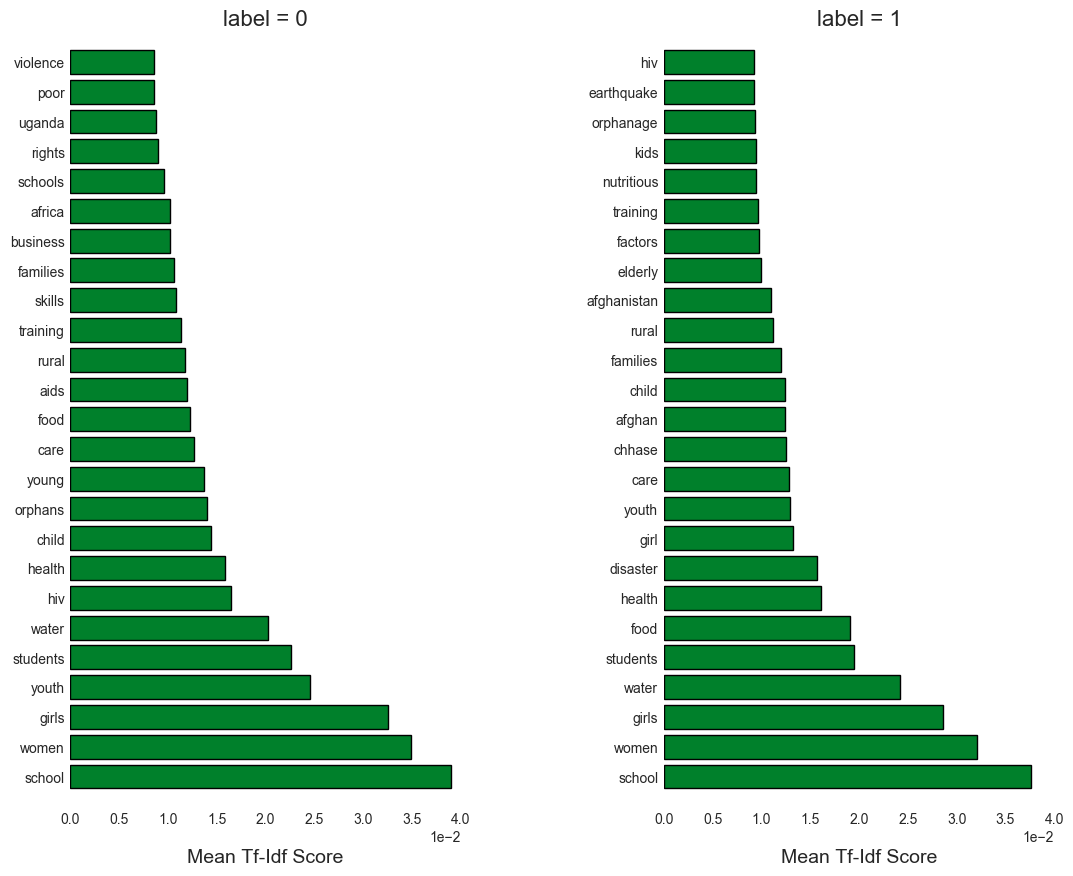

In [283]:
dfs = top_feats_by_class(combined_text_tfidf,Y,features)
plot_tfidf_classfeats_h(dfs)

In [52]:
# output from tfidf vectorizer reduced using svd - the number of features output changed iteratively 
# based on output from models

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(150)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_lsa = lsa.fit_transform(combined_text_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of projects our solution considers similar, for the first five identified topics
projects_by_component=pd.DataFrame(X_lsa,index=df_text_features)
# for i in range(5):
#     print('Component {}:'.format(i))
#     print(projects_by_component.loc[:,i].sort_values(ascending=False)[0:10])



Percent variance captured by all components: 40.0653297823


In [85]:
df_text_analysis = projects_by_component.set_index(df_cont_cat.index,drop=True)
df_text_analysis.shape
#print(df_text_analysis.head())

(16030, 150)

### Create Custom Features using Spacy

In [139]:
# custom features
count_list_title = []
summary_list_title = []
#1. counts of words in title, summary
for i in df_text_features['title_tokenized']:
    count_list_title.append(len(i))
features_final['title_counts'] = count_list_title  

for i in df_text_features['summary_tokenized']:
    summary_list_title.append(len(i))
features_final['summary_counts'] = summary_list_title  
# # count the number of words
ints = []
for i in df_text_features['longTermImpact_tokenized']:
    n=0
    for token in i:
        if token.is_digit == True:
            n+=1
    ints.append(n)
features_final['impact_int_count'] = ints


### Generate normalized and reduced the datasets and combine with text data

In [140]:
# normalize the data in the combined feature set (without further reducing with pca)

from sklearn import preprocessing

x = features_final.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_cont_cat = pd.DataFrame(x_scaled)
df_cont_cat.shape

(16030, 346)

In [150]:
# try reducing the dataset with pca
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 


df_pca = features_final

# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X_pca = StandardScaler().fit_transform(df_pca)
X_pca.shape
sklearn_pca = PCA(n_components=200)
Y_sklearn = sklearn_pca.fit_transform(X_pca)

variance_explained=sklearn_pca.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 97.2606282132


In [151]:
features_text_custom = pd.concat([df_cont_cat,df_text_analysis],axis=1)
features_pca = pd.DataFrame(Y_sklearn)

features_reduced = pd.concat([features_pca,df_text_analysis],axis=1)

print(features_reduced.shape)



(16030, 350)


### Create Train and Test Groups
The dataset is unbalanced (66% retired, 33% funded). To compensate for that, I employed a stratified train/test/split strategy that maintained the class proportions within the divisions. I will try two different features sets - one where only the text features have been reduced and a second that reduces the continuous and categorical feature set.

In [294]:

X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    Y,stratify=Y,
                                                    test_size=0.25,
                                                    random_state=0)

X_train2, X_test2, y_train, y_test = train_test_split(df_cont_cat, 
                                                    Y,stratify=Y,
                                                    test_size=0.25,
                                                    random_state=0)

X_train3, X_test3, y_train, y_test = train_test_split(features_reduced, 
                                                    Y,stratify=Y,
                                                    test_size=0.25,
                                                    random_state=0)



### Clustering Output
Attempting to identify patterns in data using Kmeans clustering. Output clusters could potentially be used as predictive features.

In [91]:
# clustering using k-means and tf-idf generated data
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA


# Get predicted clusters.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_train2)
crosstab_kmeans = pd.crosstab(y_train, y_pred) 
print(crosstab_kmeans)

y_pred4 = KMeans(n_clusters=4, random_state=42).fit_predict(X_train2)
crosstab_kmeans4 = pd.crosstab(y_train, y_pred4) 
print(crosstab_kmeans4)

y_pred6 = KMeans(n_clusters=6, random_state=42).fit_predict(X_train2)
crosstab_kmeans6 = pd.crosstab(y_train, y_pred6) 
print(crosstab_kmeans6)

y_pred10 = KMeans(n_clusters=10, random_state=42).fit_predict(X_train2)
crosstab_kmeans10 = pd.crosstab(y_train, y_pred10) 
print(crosstab_kmeans10)





col_0       0     1
status             
funded   2064  2258
retired  2467  5233
col_0       0     1    2     3
status                        
funded   1087  1935  592   708
retired  1747  2334  998  2621
col_0      0     1     2     3     4    5
status                                   
funded   592   542  1080   594  1400  114
retired  998  1084  1742  2057  1255  564
col_0       0    1     2    3    4    5    6    7    8    9
status                                                     
funded    317  917   542  569  573  105  321  103  422  453
retired  1484  619  1084  979  705  556  688  406  291  888


### Run Models to Predict Funding

In [166]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
train = rfc.fit(X_train3, y_train)

print('Training set score:', rfc.score(X_train3, y_train))
print('\nTest set score:', rfc.score(X_test3, y_test))

predictions = rfc.predict(X_test3)
print(pd.crosstab(predictions,y_test))
print('F1 score:', metrics.f1_score(y_test, predictions, labels=None, pos_label=1, average=None, sample_weight=None))

Training set score: 0.9815338546

Test set score: 0.709580838323
status_binary     0    1
row_0                   
0              2252  849
1               315  592
F1 score: [ 0.79463656  0.50425894]


In [167]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2')

train2 = lr.fit(X_train3, y_train)
print('Training set score:', lr.score(X_train3, y_train))
print('Test set score:', lr.score(X_test3, y_test))
predictions = lr.predict(X_test3)
print(pd.crosstab(predictions,y_test))
print('F1 score:', metrics.f1_score(y_test, predictions, labels=None, pos_label=1, average=None, sample_weight=None))

Training set score: 0.73922808185
Test set score: 0.730538922156
status_binary     0    1
row_0                   
0              2219  732
1               348  709
F1 score: [ 0.80427691  0.56765412]


In [295]:
# Instantiate our model and store it in a new variable.
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()

bnb.fit(X_train3,y_train)
y_pred_bnb = bnb.predict(X_test3)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    X_test3.shape[0],
    (y_test != y_pred_bnb).sum()
))
print(bnb.score(X_train3,y_train))
correctlylabeled = X_test3.shape[0] - (y_test != y_pred_bnb).sum()
print('% Accurately Predicted: ',(correctlylabeled /X_test3.shape[0] ) * 100)
print('F1 score:', metrics.f1_score(y_test, y_pred_bnb, labels=None, pos_label=1, average=None, sample_weight=None))

Number of mislabeled points out of a total 4008 points : 1354
0.666444851106
% Accurately Predicted:  66.2175648703
F1 score: [ 0.73251679  0.54163846]


In [169]:
#modified from
#https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

def model_fit(alg, X_train, y_train, X_test, y_test,cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)
    # predict training set
    y_pred = alg.predict(X_train)
    y_pred_test = alg.predict(X_test)
    #return the probability of sample for 2nd class
    y_pred_probabilities = alg.predict_proba(X_train)[:,1]
  
    #cross-validation
    #cv_score = cross_validation.cross_val_score(alg,X_train,y_train,cv=cv_folds,scoring='roc_auc')
    
    #print Output
    print('Output:')
    print('Accuracy Train: ',metrics.accuracy_score(y_train,y_pred))
    print('Accuracy Test: ',metrics.accuracy_score(y_test,y_pred_test))
   

In [170]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error


#create a baseline model for gradient boost
gbm_start = ensemble.GradientBoostingClassifier(random_state=10)
model_fit(gbm_start,X_train3,y_train,X_test3,y_test)

Output:
Accuracy Train:  0.772084511728
Accuracy Test:  0.7250499002


In [171]:

gbm = ensemble.GradientBoostingClassifier(n_estimators=600,learning_rate=0.1, min_samples_split=800,\
                                                               min_samples_leaf=80,max_depth=10,
                                                               max_features='sqrt',\
                                                               subsample=0.8,random_state=10)
print('1')
gbm.fit(X_train3, y_train)
    # predict training set
print('2')
y_pred = gbm.predict(X_train3)
y_pred_test = gbm.predict(X_test3)
    
print('Output:')
print('Accuracy Train: ',metrics.accuracy_score(y_train,y_pred))
print('Accuracy Test: ',metrics.accuracy_score(y_test,y_pred_test))
print('F1 score:', metrics.f1_score(y_test, y_pred_test, labels=None, pos_label=1, average=None, sample_weight=None))



1
2
Output:
Accuracy Train:  0.991432373981
Accuracy Test:  0.755738522954
F1 score: [ 0.81900536  0.62447257]


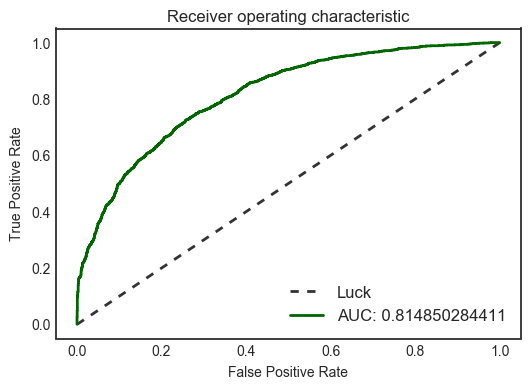

In [290]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Plot ROC for bnb output


probs = gbm.predict_proba(X_test3)
preds = probs[:,1]


fpr, tpr, thresholds = roc_curve(y_test,preds)
roc_auc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
         label='Luck', alpha=.8)
label_string = 'AUC: '+ str(roc_auc)
plt.plot(fpr, tpr, lw=2, alpha=1,label=label_string, color='#006600')


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('roc.png')
plt.show()

### Outcome:
By using a Gradient Boost Classifier, I was able to predict funded versus retired projects on GlobalGiving with 76% accuracy using the test feature set. I ultimately chose this model based on performance after trying other models including naive bayes, logistic regression and random forest. The model was ultimately did not benefit much from the tf-idf output (about 2-3% in accuracy). More custom features and further optimizing parameters could likely further improve the predictability.

### References
1. Data obtained from: https://www.globalgiving.org/api/
2. BaseMap code example utilized: http://ramiro.org/notebook/basemap-choropleth/
3. Gradient Boost parameter optimization: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/